# Small Hydrocarbon Cracking
This Notebook showcases a typical application of on-line GC using the cracking of 2,4 dimethylpentane with a zeolite catalyst as an exmple.

In [67]:
import chromstream as cs
import pandas as pd
from pathlib import Path
from chromstream.data_processing import time_window_baseline

## Setup and Parsing
We first set up an Experiment object and add the chromatograms to it. The GC used here generates ASCII files that contains chromatograms of all three channels, and therefore require a dedicated parser.
As a baseline, the mean value in a specified time window is subtracted.

In [68]:
data_home = Path("../..") / "dev_data" / "chroms" /  "MTO_setup"
paths_all = sorted((data_home).iterdir())
# Initialize an Experiment
exp_mto = cs.Experiment("Cracking test")

for path in paths_all:
    Chrom1, Chrom2, Chrom3 = cs.parse_MTO_asc(path)
    # Applying baseline (mean in a specified time window)
    Chrom1.apply_baseline(time_window_baseline, time_window=(288,294),inplace=True)
    Chrom2.apply_baseline(time_window_baseline, time_window=(288,294),inplace=True)
    Chrom3.apply_baseline(time_window_baseline, time_window=(10,15),inplace=True)
    # Adding chromatograms to the experiment
    exp_mto.add_chromatogram(Chrom1)
    exp_mto.add_chromatogram(Chrom2)
    exp_mto.add_chromatogram(Chrom3)

We can get a quick look at the chromatograms using the integrated plotting method:

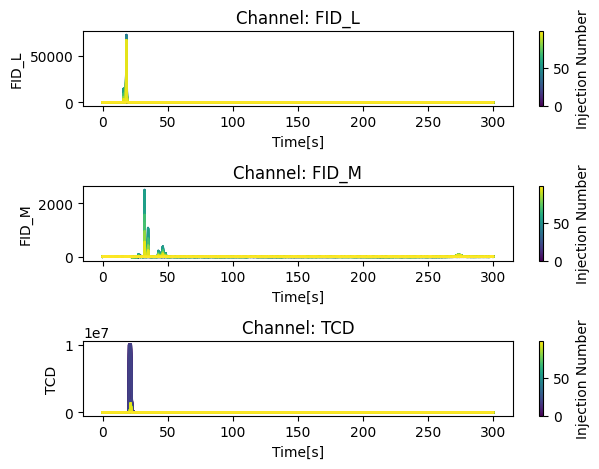

In [69]:
exp_mto.plot_chromatograms()

We parse the corresponding log file and also add it to the experiment object.
This enables the access to the log data from the Experiment object.
You can try if the general log file parser included in this package (cs.parse_log_file()) can handle your logfile. If not, you can also feed a pandas dataframe to the .add_log() method. To enable other functionality, this dataframe must contain a 'Timestamp' column containing pd.DataTime objects.

In [70]:
log_path = Path("../..")/ "dev_data" / "logs" / "MTO"
logs = sorted((log_path).iterdir())
log_data = cs.parse_log_MTO(logs[0])
exp_mto.add_log(log_data)

With all channels parsed, we can now begin integrating the data. For this we can use the .integrate peaks method. A peak is described by a dict with integration boundries, which need to be specified manually. The resulting unit of the integral is the the unit of the signal multiplied by the recorded unit of the retention time. Some programs save in minutes, while others in seconds. Keep track of your units. 

In [71]:
Peaks_FID_L = {'DMP_L': [17.7,24], 'Rest': [14,17.7]}

Peaks_FID_M = {'DMP': [255,280],
               'Butane': [34,38],
               'Propane': [29,34],
               'Ethane': [27.87,29.26],
               'Methane': [27.5,27.87],
               'ALL_products':[26,150]}

Peaks_TCD = {"N2": [20, 26], "H2": [16, 19]}

integrals_FID_L = exp_mto.channels['FID_L'].integrate_peaks(peaklist=Peaks_FID_L,).set_index('Timestamp')
integrals_FID_M = exp_mto.channels['FID_M'].integrate_peaks(peaklist=Peaks_FID_M,).set_index('Timestamp')
integrals_TCD = exp_mto.channels['TCD'].integrate_peaks(peaklist=Peaks_TCD,).set_index('Timestamp')


We then combine all integrated channels to an 'Analysis' dataframe. We then add extra data from the logfile using the dedicated cs.get_temp_and_valves_MTO method.
For a more general approach, you can use the function below as follows:

```python

new_df = cs.add_log_data(Analysis, Log_data)
```
This function takes in a dataframe containing a timestamp column, and adds entries from the Log_data file at the appropriate time.
Note that this approach relies on the the log data having signifcantly better time resolution.

We also begin to filter the experiment, in this case we skip the heatup phase of the reactor by only including the data where the carrier gas is flown into the saturator. The last five time injections are skipped, and the experiment start time is set.

In [72]:
# import chromstream.data_processing as csd

# Combining all integral frames for analysis
Analysis = pd.concat([integrals_FID_L, integrals_FID_M, integrals_TCD], axis=1)
# Adding log data
Analysis = cs.get_temp_and_valves_MTO(Analysis, exp_mto.log)

Analysis = Analysis[Analysis['v10-bubbler'] == 1] # skip the heatup phase, experiemnts starts when the flow over the bubbler is started
# Setting experiment start time
exp_mto.experiment_starttime = Analysis.index.min()
# Add an 'Experiment_time' column in minutes
Analysis['Experiment_time(min)'] = (Analysis.index - exp_mto.experiment_starttime).total_seconds() / 60.0 # type: ignore
# dropping the last couple datapoints
Analysis = Analysis[:-5]

In [73]:
Analysis

,DMP_L,Rest,DMP,Butane,Propane,Ethane,Methane,ALL_products,N2,H2,Oven Temperature,v10-bubbler,v11-reactor,Experiment_time(min)
Timestamp,,,,,,,,,,,,,,
2024-01-19 19:44:55,31392.331793,1.452073,246.772513,2.376192,-3.162931,-2.803507,-0.143770,7.100620,1.071223e+06,-0.409145,515.0,1.0,bypass,0.000000
2024-01-19 19:50:16,31560.053130,8.138823,282.637634,7.887359,10.861992,1.449078,0.868808,-25.423855,1.146308e+06,-40.037706,515.0,1.0,bypass,5.350000
2024-01-19 19:55:36,31368.433294,11.894537,357.290991,-19.914750,-22.487561,-6.191677,-1.293394,-276.501135,1.172510e+06,-19.233478,515.0,1.0,bypass,10.683333
2024-01-19 20:00:55,31746.996460,13.234923,329.950408,2.968576,5.372190,1.232824,0.518902,147.709408,1.196526e+06,-30.714600,515.0,1.0,bypass,16.000000
2024-01-19 20:06:15,31470.195805,16.970003,304.686298,-6.486272,-4.417520,-0.551716,0.081403,-132.612736,1.190216e+06,48.346224,515.0,1.0,bypass,21.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-20 00:54:09,29030.636607,1191.277744,275.294602,84.151802,169.262932,4.652743,4.428170,232.036995,1.167079e+06,44.945459,470.0,1.0,reactor,309.233333
2024-01-20 00:59:28,29141.897629,1182.424599,247.177863,83.922170,168.006746,4.658534,4.447539,273.574226,1.169290e+06,-92.358158,470.0,1.0,reactor,314.550000
2024-01-20 01:04:49,28927.047823,1146.061409,312.909119,87.792633,174.100380,6.391157,4.666055,236.998909,1.165463e+06,84.385915,470.0,1.0,reactor,319.900000


Lets take a look at the data we have so far by plotting the raw integral of the DMP compound on the FID_L channel.
The reaction is conducted using a multi-step temperature programm to investigate the effect of the temperature on the conversion.

Text(0, 0.5, 'Oven Temperature (°C)')

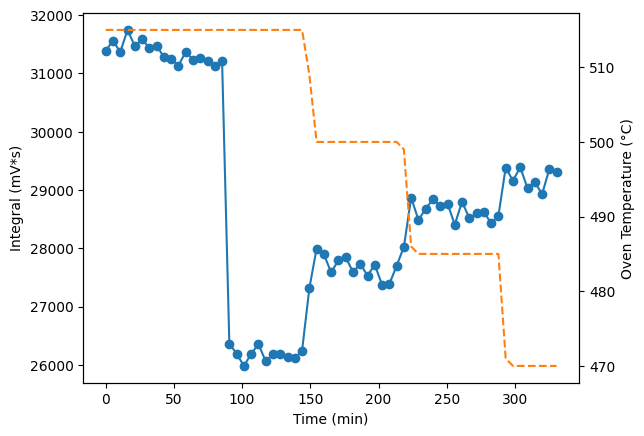

In [74]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(Analysis['Experiment_time(min)'], Analysis['DMP_L'], label='DMP_L', color='C0', marker='o')
ax2.plot(Analysis['Experiment_time(min)'], Analysis['Oven Temperature'], color='C1', label='Oven Temp', linestyle='--')

ax.set_xlabel('Time (min)')
ax.set_ylabel(f'Integral ({exp_mto.channels["FID_L"].chromatograms[0].signal_unit}*{exp_mto.channels["FID_L"].chromatograms[0].time_unit})')
ax2.set_ylabel('Oven Temperature (°C)')

Working with absolute values is not ideal, so lets normalize the data. In this example we initally dont care about absolute units, as we only investigate conversion. To normalize, the area of the DMP peak in the last 5 chromatograms where the the v11 valve is set to bypass is obtained, so that the DMP flow goes straight to the GC, rather than the reactor.

(80.0, 102.5347920562692)

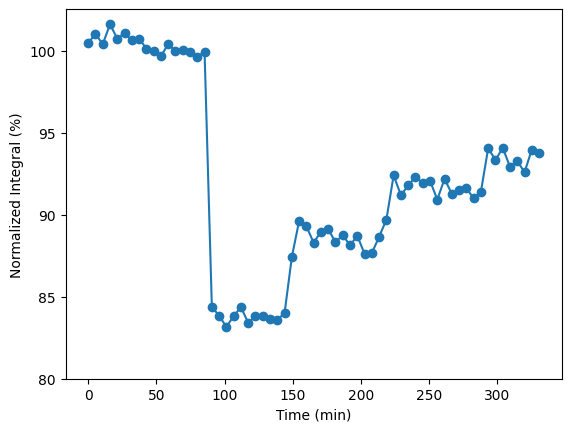

In [75]:
no_chromatograms_norm = 5 # we normalize by the last 5 chromatograms
idx = Analysis[Analysis['v11-reactor'] == 'bypass'].index # get the indeces in the integral frame where the reactor is bypassed
idx_norm = idx[-(no_chromatograms_norm+1):-1]
norm_DMP_L = Analysis['DMP_L'][idx_norm].mean() 

fig, ax = plt.subplots()
ax.plot(Analysis['Experiment_time(min)'], 100*Analysis['DMP_L']/norm_DMP_L, label='DMP_L normalized',marker='o', color='C0')
ax.set_xlabel('Time (min)')
ax.set_ylabel('Normalized Integral (%)')
ax.set_ylim(80, )

The data is still quite noisy. The problem is the following: We bubble 1.5 mL N2 though a DMP saturator, which then gets diluted by 50 mL He. This means that a small deviation of the N2 mass flow controller can have a big effect. However, because we can detect N2 on the TCD channel of the GC, we can use it to correct for this effect! Lets also add the integral of the products and the reactor temperature on the second axis.

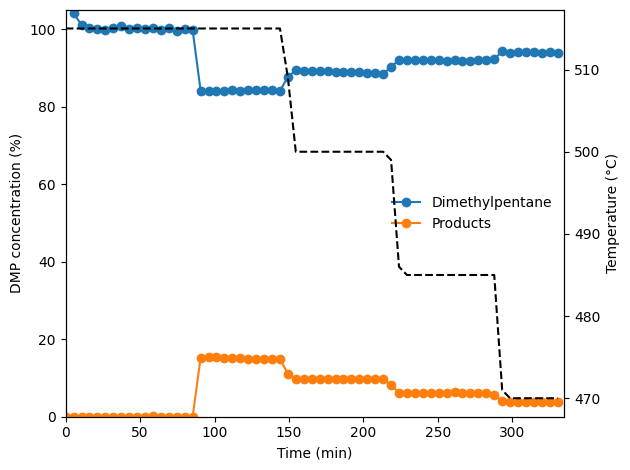

In [76]:
fig, ax = plt.subplots(tight_layout=True)

Analysis['N2corr']= Analysis['N2']/Analysis.loc[idx_norm]['N2'].mean()
Analysis['Conversion_norm'] = Analysis['DMP_L']/norm_DMP_L*100/Analysis['N2corr']
Analysis['Products_norm'] = Analysis['Rest']/norm_DMP_L*100/Analysis['N2corr']

ax.plot(Analysis['Experiment_time(min)'],Analysis['Conversion_norm'],label='Dimethylpentane',marker = 'o')
ax.plot(Analysis['Experiment_time(min)'],Analysis['Products_norm'],label='Products',marker = 'o')

ax.set_xlabel('Time (min)')
ax.set_ylabel('DMP concentration (%)')
ax.set_xlim(0,335)
ax.set_ylim(0,105)

#plotting the temperature
ax2 = ax.twinx()
ax2.plot(Analysis['Experiment_time(min)'], Analysis['Oven Temperature'], label='Temperature',color='black', linestyle = '--')

# Note: You can also plot the log directly, it will have a higher time resolution
# temp_df = exp_mto.log[['Timestamp', 'Oven Temperature']]
# temp_df['Experiment_time(min)'] = (temp_df['Timestamp'] - exp_mto.experiment_starttime).dt.total_seconds() / 60.0 # type: ignore
# ax2.plot(temp_df['Experiment_time(min)'], temp_df['Oven Temperature'], label='Temperature',color='gray', linestyle = '--', alpha=0.5)

ax2.set_ylabel('Temperature (°C)')
ax.legend(frameon=False)
plt.show()

As you can see the data is not singficantly less noisy, and we can read out the conversion at different temperatures.
To get more quantitaive results, we will requiere the partial pressure of DMP entering the reactor.
With a calibration we can determine first the vol% and then the partial pressure of DMP at the start of the experiment as follows:

In [77]:
import numpy as np
# CF = peak_area/concentration, so concentration = peak_area/CF
# The *7 accounts for the 7 carbon atoms in DMP (dimethylpentane)
calibration_factor = 7463915.174603943 *7 
vol_pct = norm_DMP_L / calibration_factor  # see the calibration notebook for determination of the calibration factor.
partial_pressure_kpa = vol_pct*10**6/100 # assuming 10^6 pa normal pressure

print('The volume fraction is ' +str(np.round(vol_pct*100,4)) + '%') # in Pa
print('The pressure of DMP is ' +str(np.round(partial_pressure_kpa,4)) + ' kPa') # in kPa

The volume fraction is 0.0598%
The pressure of DMP is 5.9799 kPa
